# Feature Selection Experiments for openSMILE

The [openSMILE Python API](https://audeering.github.io/opensmile-python/) includes the [ComParE 2016](http://www.tangsoo.de/documents/Publications/Schuller16-TI2.pdf) feature set which enables us to extract 65 low-level descriptors (for ex. MFCC) as well as 6373 Functionals derived from these decriptors. 

For each audio file - the LLDs are a `samples x 65` df and the functionals are a `1 x 6373` df. 

In these experiments, we extract the functionals for both real and fake audio data and run a set of feature selection techniques to identify a hnadful subset of features for use in a final predictive model.

## Import Statements

In [1]:
import opensmile 
import pandas as pd
import numpy as np
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, confusion_matrix
import random
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsClassifier
import seaborn as sns
from sklearn import svm
from pprint import pprint
from tqdm import tqdm
base_path = "/home/ubuntu/"

## Data Loading and Summary

To save time, the data is sampled and features are extracted using openSMILE in a separate notebook `sampling_and_mixing_data.ipynb` and saved in `.csv` format for reusability. The dataset used contains original audio from the [LJSpeech 1.1](https://keithito.com/LJ-Speech-Dataset/) dataset and fake audio generated using GANs for the [NeurIPS 2021 WaveFake](https://arxiv.org/abs/2111.02813) dataset. It also contains audio from LJSpeech generated using ElevenLabs.

Contains 12,800 audio files - 6400 each real and fake with a set of 800 real audio files matching a set of the same 800 fakes generated using one of the archs listed below. 

In [2]:
exp_data_file = '/home/ubuntu/testing-code/opensmile-feature-importance/smile_dfs/0310-lj_experimental_data_v1.csv'
exp_data_df = pd.read_csv(exp_data_file)

In [3]:
exp_data_df.head()

,id,file,type,fake,duration(seconds),audspec_lengthL1norm_sma_range,audspec_lengthL1norm_sma_maxPos,audspec_lengthL1norm_sma_minPos,audspec_lengthL1norm_sma_quartile1,audspec_lengthL1norm_sma_quartile2,...,mfcc_sma_de[14]_peakRangeAbs,mfcc_sma_de[14]_peakRangeRel,mfcc_sma_de[14]_peakMeanAbs,mfcc_sma_de[14]_peakMeanMeanDist,mfcc_sma_de[14]_peakMeanRel,mfcc_sma_de[14]_minRangeRel,mfcc_sma_de[14]_meanRisingSlope,mfcc_sma_de[14]_stddevRisingSlope,mfcc_sma_de[14]_meanFallingSlope,mfcc_sma_de[14]_stddevFallingSlope
0,LJ032-0137,/home/ubuntu/data/wavefake_data/LJSpeech_1.1/w...,ElevenLabs,0,7.762,2.529597,0.608866,0.765319,0.343702,0.589645,...,10.773912,0.657822,2.936347,2.935397,20.000000,0.609994,129.240130,64.158455,130.97571,60.847908
1,LJ038-0165,/home/ubuntu/data/wavefake_data/LJSpeech_1.1/w...,ElevenLabs,0,8.656,2.406416,0.005841,0.695093,0.295922,0.514596,...,8.458103,0.531263,2.910538,2.911863,-20.000000,0.650057,125.028530,58.838596,115.42761,55.276188
2,LJ044-0203,/home/ubuntu/data/wavefake_data/LJSpeech_1.1/w...,ElevenLabs,0,5.150,2.695161,0.249012,0.175889,0.375376,0.674925,...,11.555664,0.663116,2.731076,2.731820,-20.000000,0.479881,126.260170,54.306473,109.07703,62.240750
3,LJ003-0044,/home/ubuntu/data/wavefake_data/LJSpeech_1.1/w...,ElevenLabs,0,3.199,2.287197,0.528846,0.996795,0.478625,0.801715,...,11.162925,0.497092,3.827386,3.820832,19.997963,0.526514,155.382830,77.223274,146.11166,88.627940
4,LJ036-0116,/home/ubuntu/data/wavefake_data/LJSpeech_1.1/w...,ElevenLabs,0,2.340,2.027513,0.181416,0.513274,0.277241,0.572403,...,6.160469,0.462080,2.797420,2.774368,19.579084,0.638266,99.164055,44.689617,123.44574,49.456890


In [4]:
exp_data_df.shape

(12800, 6378)

In [5]:
exp_data_df.type.value_counts()

ElevenLabs           1600
Waveglow             1600
Parallel_WaveGan     1600
Multi_Band_MelGan    1600
MelGanLarge          1600
MelGan               1600
HifiGan              1600
Full_Band_MelGan     1600
Name: type, dtype: int64

In [6]:
#check to ensure each id has a corresponding fake
exp_data_df.id.value_counts()

LJ032-0137    2
LJ038-0118    2
LJ046-0168    2
LJ016-0171    2
LJ037-0020    2
             ..
LJ004-0171    2
LJ042-0184    2
LJ015-0150    2
LJ007-0172    2
LJ028-0069    2
Name: id, Length: 6400, dtype: int64

## Train-Dev-Test Split:

In [7]:
#split the data 
f1 = 0.8
f2 = 0.9
train_df, dev_df, test_df = np.split(exp_data_df.sample(frac=1), [int(f1*len(exp_data_df)), int(f2*len(exp_data_df))])

In [8]:
#check split
len(train_df), len(dev_df), len(test_df), (len(train_df) + len(dev_df) + len(test_df))

(10240, 1280, 1280, 12800)

In [9]:
train_df.type.value_counts()

MelGanLarge          1315
MelGan               1287
Full_Band_MelGan     1284
ElevenLabs           1277
HifiGan              1274
Waveglow             1273
Parallel_WaveGan     1267
Multi_Band_MelGan    1263
Name: type, dtype: int64

In [10]:
dev_df.type.value_counts()

ElevenLabs           184
Waveglow             170
MelGan               163
Full_Band_MelGan     163
Parallel_WaveGan     161
Multi_Band_MelGan    160
HifiGan              151
MelGanLarge          128
Name: type, dtype: int64

In [11]:
test_df.type.value_counts()

Multi_Band_MelGan    177
HifiGan              175
Parallel_WaveGan     172
MelGanLarge          157
Waveglow             157
Full_Band_MelGan     153
MelGan               150
ElevenLabs           139
Name: type, dtype: int64

## Feature Scaling:

In [12]:
exp_data_scaler = StandardScaler()
train_df.iloc[:,5:] = exp_data_scaler.fit_transform(train_df.iloc[:,5:])
dev_df.iloc[:,5:] = exp_data_scaler.transform(dev_df.iloc[:,5:])
test_df.iloc[:,5:] = exp_data_scaler.transform(test_df.iloc[:,5:])

## Experiment 1: Brute Force Feature Selection

In the first experiment, we break down the data set into each architecture used to generate fakes 

In [13]:
def run_bflr_for_arch(train_df, dev_df, arch, all_archs=False):
    
    #prepare data
    if all_archs==False:
        trdf = train_df[train_df.type==arch]
    if all_archs==True:
        trdf = train_df[train_df.type.isin(arch)]
    
    if all_archs==False:
        dvdf = dev_df[dev_df.type==arch]
    if all_archs==True:
        dvdf = dev_df[dev_df.type.isin(arch)]
    
    X_train = trdf.drop(columns=['id', 'file', 'type', 'duration(seconds)', 'fake']).copy()
    y_train = trdf['fake'].copy()
    
    X_dev = dvdf.drop(columns=['id', 'file', 'type', 'duration(seconds)', 'fake'])
    y_dev = dvdf['fake'].copy()
    
    train_accuracies = []
    dev_accuracies = []
    
    for i in tqdm(range(6373)):
        
        model_lr = LogisticRegression()
        model_lr.fit(X_train.iloc[:,i].to_numpy().reshape(-1, 1), y_train)
        y_hat_train = model_lr.predict(X_train.iloc[:,i].to_numpy().reshape(-1, 1))
        y_hat_dev = model_lr.predict(X_dev.iloc[:,i].to_numpy().reshape(-1, 1))
        train_accuracy = accuracy_score(y_train, y_hat_train)
        train_accuracies.append(train_accuracy)        
        dev_accuracy = accuracy_score(y_dev, y_hat_dev)
        dev_accuracies.append(dev_accuracy)
    
    print("\nAverage train accuracy: {}".format(np.mean(train_accuracies)))
    print("Average dev accuracy: {}\n".format(np.mean(dev_accuracies)))
    
    return dev_accuracies

In [14]:
archs = list(exp_data_df.type.unique())
features = train_df.columns.to_list()[5:]
bruteforce_df = pd.DataFrame(features, columns=['features'])

for arch in archs:
    print("\nRunning for {} architecture\n".format(arch))
    bruteforce_df[arch] = run_bflr_for_arch(train_df, dev_df, arch)

print("\nRunning for all architectures\n")
bruteforce_df['all_archs'] = run_bflr_for_arch(train_df, dev_df, archs, all_archs=True)


Running for ElevenLabs architecture



100%|██████████| 6373/6373 [00:13<00:00, 475.99it/s]



Average train accuracy: 0.6236833125653313
Average dev accuracy: 0.6231699288438316


Running for Waveglow architecture



100%|██████████| 6373/6373 [00:12<00:00, 526.67it/s]



Average train accuracy: 0.5306903424193953
Average dev accuracy: 0.5031603917261239


Running for Parallel_WaveGan architecture



100%|██████████| 6373/6373 [00:12<00:00, 522.13it/s]



Average train accuracy: 0.5367886744975691
Average dev accuracy: 0.4747386343590439


Running for Multi_Band_MelGan architecture



100%|██████████| 6373/6373 [00:12<00:00, 529.76it/s]



Average train accuracy: 0.5266426714344052
Average dev accuracy: 0.5093068413619959


Running for MelGanLarge architecture



100%|██████████| 6373/6373 [00:12<00:00, 526.90it/s]



Average train accuracy: 0.5275922245643008
Average dev accuracy: 0.5261920406402009


Running for MelGan architecture



100%|██████████| 6373/6373 [00:12<00:00, 521.87it/s]



Average train accuracy: 0.526572073253385
Average dev accuracy: 0.5051227427057592


Running for HifiGan architecture



100%|██████████| 6373/6373 [00:11<00:00, 533.20it/s]



Average train accuracy: 0.5149264669114033
Average dev accuracy: 0.5097540015150838


Running for Full_Band_MelGan architecture



100%|██████████| 6373/6373 [00:12<00:00, 530.66it/s]



Average train accuracy: 0.5168240430202767
Average dev accuracy: 0.4804009245291919


Running for all architectures



100%|██████████| 6373/6373 [00:26<00:00, 238.45it/s]


Average train accuracy: 0.5163051000068649
Average dev accuracy: 0.5117451063078613



In [15]:
bruteforce_df[(bruteforce_df.iloc[:,1:] > 0.55).all(1)]

,features,ElevenLabs,Waveglow,Parallel_WaveGan,Multi_Band_MelGan,MelGanLarge,MelGan,HifiGan,Full_Band_MelGan,all_archs
68,pcm_RMSenergy_sma_iqr1-2,0.586957,0.564706,0.608696,0.63125,0.562500,0.564417,0.682119,0.576687,0.596094
1436,pcm_fftMag_spectralSlope_sma_percentile99.0,0.956522,0.564706,0.670807,0.56875,0.593750,0.613497,0.562914,0.564417,0.589844
2796,pcm_fftMag_fband1000-4000_sma_de_iqr1-2,0.625000,0.611765,0.577640,0.55625,0.570312,0.588957,0.576159,0.601227,0.550781
2798,pcm_fftMag_fband1000-4000_sma_de_iqr1-3,0.603261,0.605882,0.608696,0.56250,0.562500,0.570552,0.582781,0.644172,0.557813
3776,jitterDDP_sma_flatness,0.684783,0.747059,0.664596,0.77500,0.671875,0.705521,0.794702,0.619632,0.670312
4177,pcm_RMSenergy_sma_amean,0.646739,0.570588,0.645963,0.65625,0.617188,0.564417,0.589404,0.564417,0.600781


In [16]:
bruteforce_df[(bruteforce_df.iloc[:,1:] > 0.6).all(1)]

,features,ElevenLabs,Waveglow,Parallel_WaveGan,Multi_Band_MelGan,MelGanLarge,MelGan,HifiGan,Full_Band_MelGan,all_archs
3776,jitterDDP_sma_flatness,0.684783,0.747059,0.664596,0.775,0.671875,0.705521,0.794702,0.619632,0.670312


In [17]:
bruteforce_df[(bruteforce_df.iloc[:,2:-1] > 0.55).all(axis=1)]

,features,ElevenLabs,Waveglow,Parallel_WaveGan,Multi_Band_MelGan,MelGanLarge,MelGan,HifiGan,Full_Band_MelGan,all_archs
4,audspec_lengthL1norm_sma_quartile2,0.875000,0.611765,0.639752,0.58750,0.617188,0.576687,0.556291,0.601227,0.528125
5,audspec_lengthL1norm_sma_quartile3,0.923913,0.588235,0.596273,0.62500,0.570312,0.552147,0.589404,0.588957,0.469531
68,pcm_RMSenergy_sma_iqr1-2,0.586957,0.564706,0.608696,0.63125,0.562500,0.564417,0.682119,0.576687,0.596094
1089,pcm_fftMag_fband1000-4000_sma_quartile2,0.510870,0.605882,0.596273,0.59375,0.593750,0.595092,0.622517,0.650307,0.587500
1091,pcm_fftMag_fband1000-4000_sma_iqr1-2,0.489130,0.582353,0.602484,0.59375,0.585938,0.595092,0.602649,0.638037,0.578125
1436,pcm_fftMag_spectralSlope_sma_percentile99.0,0.956522,0.564706,0.670807,0.56875,0.593750,0.613497,0.562914,0.564417,0.589844
2793,pcm_fftMag_fband1000-4000_sma_de_quartile1,0.625000,0.600000,0.583851,0.56250,0.570312,0.582822,0.569536,0.582822,0.550000
2796,pcm_fftMag_fband1000-4000_sma_de_iqr1-2,0.625000,0.611765,0.577640,0.55625,0.570312,0.588957,0.576159,0.601227,0.550781
2798,pcm_fftMag_fband1000-4000_sma_de_iqr1-3,0.603261,0.605882,0.608696,0.56250,0.562500,0.570552,0.582781,0.644172,0.557813
2955,pcm_fftMag_spectralFlux_sma_de_percentile99.0,0.815217,0.570588,0.658385,0.66250,0.617188,0.601227,0.642384,0.570552,0.535937


In [18]:
bruteforce_df[(bruteforce_df.iloc[:,2:-1] > 0.9).any(axis=1)]

,features,ElevenLabs,Waveglow,Parallel_WaveGan,Multi_Band_MelGan,MelGanLarge,MelGan,HifiGan,Full_Band_MelGan,all_archs
1702,mfcc_sma[6]_lpc2,0.695652,0.494118,0.571429,0.52500,0.914062,0.901840,0.543046,0.546012,0.567969
1762,mfcc_sma[8]_lpc0,0.717391,0.582353,0.496894,0.53750,0.906250,0.901840,0.463576,0.539877,0.582031
1763,mfcc_sma[8]_lpc1,0.619565,0.500000,0.428571,0.53750,0.937500,0.932515,0.529801,0.546012,0.604688
1794,mfcc_sma[9]_lpc1,0.559783,0.517647,0.428571,0.53750,0.890625,0.907975,0.569536,0.527607,0.587500
1825,mfcc_sma[10]_lpc1,0.690217,0.535294,0.447205,0.50625,0.906250,0.895706,0.503311,0.533742,0.613281
1856,mfcc_sma[11]_lpc1,0.739130,0.505882,0.515528,0.48750,0.937500,0.920245,0.582781,0.570552,0.618750
1885,mfcc_sma[12]_lpgain,0.755435,0.611765,0.639752,0.62500,0.906250,0.883436,0.569536,0.539877,0.596094
1886,mfcc_sma[12]_lpc0,0.782609,0.529412,0.534161,0.56250,0.914062,0.926380,0.516556,0.496933,0.603125
1887,mfcc_sma[12]_lpc1,0.597826,0.511765,0.534161,0.49375,0.898438,0.944785,0.569536,0.558282,0.607812
1916,mfcc_sma[13]_lpgain,0.711957,0.594118,0.652174,0.53750,0.906250,0.883436,0.516556,0.533742,0.573438


In [19]:
bruteforce_df[(bruteforce_df.iloc[:,-1] > 0.60)]

,features,ElevenLabs,Waveglow,Parallel_WaveGan,Multi_Band_MelGan,MelGanLarge,MelGan,HifiGan,Full_Band_MelGan,all_archs
66,pcm_RMSenergy_sma_quartile2,0.679348,0.576471,0.645963,0.65000,0.625000,0.539877,0.602649,0.539877,0.603125
67,pcm_RMSenergy_sma_quartile3,0.625000,0.582353,0.652174,0.65000,0.593750,0.552147,0.589404,0.546012,0.601562
1088,pcm_fftMag_fband1000-4000_sma_quartile1,0.755435,0.605882,0.590062,0.59375,0.578125,0.625767,0.549669,0.588957,0.610156
1314,pcm_fftMag_spectralEntropy_sma_stddev,0.581522,0.605882,0.521739,0.51875,0.679688,0.693252,0.562914,0.607362,0.603125
1607,mfcc_sma[3]_lpc0,0.701087,0.558824,0.527950,0.47500,0.796875,0.785276,0.589404,0.533742,0.621094
1608,mfcc_sma[3]_lpc1,0.532609,0.582353,0.577640,0.52500,0.851562,0.834356,0.596026,0.527607,0.625000
1669,mfcc_sma[5]_lpc0,0.896739,0.582353,0.428571,0.51875,0.835938,0.773006,0.536424,0.496933,0.611719
1670,mfcc_sma[5]_lpc1,0.853261,0.582353,0.428571,0.55625,0.882812,0.846626,0.602649,0.509202,0.640625
1700,mfcc_sma[6]_lpc0,0.858696,0.458824,0.621118,0.54375,0.882812,0.846626,0.476821,0.533742,0.613281
1701,mfcc_sma[6]_lpc1,0.728261,0.558824,0.552795,0.47500,0.890625,0.883436,0.549669,0.533742,0.626563


In [20]:
max_idxs = []
for arch in archs + ['all_archs']:
    max_idxs.append(bruteforce_df[arch].idxmax())
bruteforce_df[bruteforce_df.index.isin(max_idxs)]

,features,ElevenLabs,Waveglow,Parallel_WaveGan,Multi_Band_MelGan,MelGanLarge,MelGan,HifiGan,Full_Band_MelGan,all_archs
96,pcm_zcr_sma_quartile1,0.994565,0.470588,0.484472,0.60000,0.476562,0.478528,0.509934,0.558282,0.545312
1887,mfcc_sma[12]_lpc1,0.597826,0.511765,0.534161,0.49375,0.898438,0.944785,0.569536,0.558282,0.607812
3407,mfcc_sma_de[6]_lpc2,0.570652,0.541176,0.453416,0.51875,0.953125,0.926380,0.562914,0.576687,0.606250
3790,jitterDDP_sma_quartile1,0.445652,0.835294,0.745342,0.86250,0.585938,0.791411,0.854305,0.705521,0.742188
3796,jitterDDP_sma_percentile1.0,0.548913,0.847059,0.652174,0.87500,0.578125,0.803681,0.827815,0.742331,0.739062


In [21]:
feats_lr_1 = bruteforce_df[(bruteforce_df.iloc[:,1:] > 0.55).all(1)].features.to_list()
feats_lr_2 = bruteforce_df[(bruteforce_df.iloc[:,1:] > 0.6).all(1)].features.to_list()
feats_lr_3 = bruteforce_df[(bruteforce_df.iloc[:,2:-1] > 0.55).all(axis=1)].features.to_list()
feats_lr_4 = bruteforce_df[(bruteforce_df.iloc[:,2:-1] > 0.9).any(axis=1)].features.to_list()
feats_lr_5 = bruteforce_df[(bruteforce_df.iloc[:,-1] > 0.60)].features.to_list()
feats_lr_6 = bruteforce_df[bruteforce_df.index.isin(max_idxs)].features.to_list()

exp_1_feature_set = set().union(feats_lr_1, feats_lr_2, feats_lr_3, feats_lr_4, feats_lr_5, feats_lr_6)

In [22]:
selected_features = list(exp_1_feature_set)

In [23]:
exp_1_feature_set

{'audspec_lengthL1norm_sma_amean',
 'audspec_lengthL1norm_sma_quartile2',
 'audspec_lengthL1norm_sma_quartile3',
 'jitterDDP_sma_flatness',
 'jitterDDP_sma_percentile1.0',
 'jitterDDP_sma_quartile1',
 'jitterDDP_sma_quartile2',
 'jitterLocal_sma_percentile1.0',
 'jitterLocal_sma_quartile1',
 'logHNR_sma_posamean',
 'mfcc_sma[10]_lpc0',
 'mfcc_sma[10]_lpc1',
 'mfcc_sma[11]_lpc0',
 'mfcc_sma[11]_lpc1',
 'mfcc_sma[12]_lpc0',
 'mfcc_sma[12]_lpc1',
 'mfcc_sma[12]_lpgain',
 'mfcc_sma[13]_lpc0',
 'mfcc_sma[13]_lpc1',
 'mfcc_sma[13]_lpgain',
 'mfcc_sma[14]_lpc1',
 'mfcc_sma[14]_lpgain',
 'mfcc_sma[3]_lpc0',
 'mfcc_sma[3]_lpc1',
 'mfcc_sma[5]_lpc0',
 'mfcc_sma[5]_lpc1',
 'mfcc_sma[6]_lpc0',
 'mfcc_sma[6]_lpc1',
 'mfcc_sma[6]_lpc2',
 'mfcc_sma[7]_lpc0',
 'mfcc_sma[7]_lpc1',
 'mfcc_sma[8]_lpc0',
 'mfcc_sma[8]_lpc1',
 'mfcc_sma[9]_lpc0',
 'mfcc_sma[9]_lpc1',
 'mfcc_sma_de[10]_lpc0',
 'mfcc_sma_de[10]_lpc1',
 'mfcc_sma_de[10]_lpc2',
 'mfcc_sma_de[11]_lpc0',
 'mfcc_sma_de[11]_lpc1',
 'mfcc_sma_de[11

In [24]:
len(exp_1_feature_set)

95

#### Test on held out test data

In [25]:
df_lr_final = pd.concat([train_df, dev_df])
X_train_lr_final = df_lr_final.drop(columns=['id', 'file', 'type', 'duration(seconds)', 'fake']).copy()
y_train_lr_final = df_lr_final['fake'].copy()

X_test_lr_final = test_df.drop(columns=['id', 'file', 'type', 'duration(seconds)', 'fake']).copy()
y_test_lr_final = test_df['fake'].copy()

In [26]:
#select features identified from brute force
feature_index = train_df.columns.intersection(selected_features)

#fit model
model_lr_final = LogisticRegression(max_iter=1000)
model_lr_final.fit(X_train_lr_final[feature_index], y_train_lr_final)

#predict on held out test data
yhat_train_final = model_lr_final.predict(X_train_lr_final[feature_index])
yhat_test_final = model_lr_final.predict(X_test_lr_final[feature_index])

#compute accuracy
accuracy_lr_train = accuracy_score(y_train_lr_final, yhat_train_final)
accuracy_lr_test = accuracy_score(y_test_lr_final, yhat_test_final)

#print
print('Logistic accuracy train = %.3f' % (accuracy_lr_train*100))
print('Logistic accuracy test = %.3f' % (accuracy_lr_test*100))

Logistic accuracy train = 92.951
Logistic accuracy test = 92.812


## SQS testing

In [27]:
X_train = train_df.drop(columns=['id', 'file', 'type', 'duration(seconds)', 'fake']).copy()
y_train = train_df['fake'].copy()

X_dev = dev_df.drop(columns=['id', 'file', 'type', 'duration(seconds)', 'fake'])
y_dev = dev_df['fake'].copy()

X_test = test_df.drop(columns=['id', 'file', 'type', 'duration(seconds)', 'fake'])
y_test = test_df['fake'].copy()

In [28]:
from sklearn.model_selection import StratifiedKFold
from yellowbrick.model_selection import RFECV

In [29]:
cv = StratifiedKFold(5)
visualizer = RFECV(LogisticRegression(max_iter=1000), step=50, cv=cv, scoring='f1_weighted')

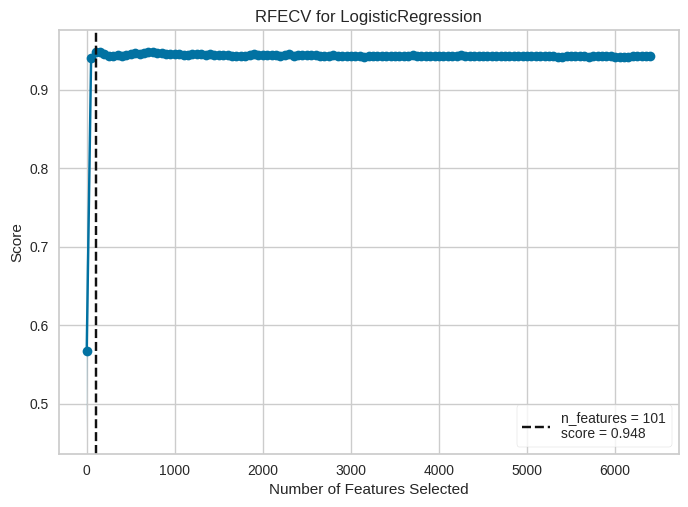

<AxesSubplot: title={'center': 'RFECV for LogisticRegression'}, xlabel='Number of Features Selected', ylabel='Score'>

In [30]:
visualizer.fit(X_train, y_train)
visualizer.show()